In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Extract ZIP safely
import zipfile, os

ZIP_PATH = "/content/drive/MyDrive/archive(2).zip"
EXTRACT_DIR = "/content"

if os.path.isfile(ZIP_PATH):
    try:
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_DIR)
        print(f"Extracted to '{EXTRACT_DIR}'")
    except zipfile.BadZipFile:
        print("Invalid zip file.")
    except Exception as e:
        print(f"Error: {e}")
else:
    print("Zip file not found.")

Extracted to '/content'


In [5]:
# ==== Imports ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pathlib
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [6]:
# ==== Data Preparation ====
IMAGE_SIZE = 224
BATCH_SIZE = 164
DATA_PATH = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"

train_dir = os.path.join(DATA_PATH, "train")
valid_dir = os.path.join(DATA_PATH, "valid")
test_dir = valid_dir  # using same folder for validation and test

In [7]:
# Train Generator
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=90,
    rescale=1/255.0,
    validation_split=0.1
).flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset="training",
    shuffle=True,
    color_mode='rgb',
    class_mode='categorical'
)

Found 63282 images belonging to 38 classes.


In [8]:
# Class labels
classes = list(train_generator.class_indices.keys())

In [9]:
# Display class index mapping
print("Class Index Mapping:\n", train_generator.class_indices)

Class Index Mapping:
 {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Soybean___healthy': 24, 'Squash___Powdery_mildew': 25, 'Strawberry___Leaf_scorch': 26, 'Strawberry___healthy': 27, 'Tomato___Bacterial_spot': 28, 'Tomato___Early_blight': 29, 'Tomato___Lat

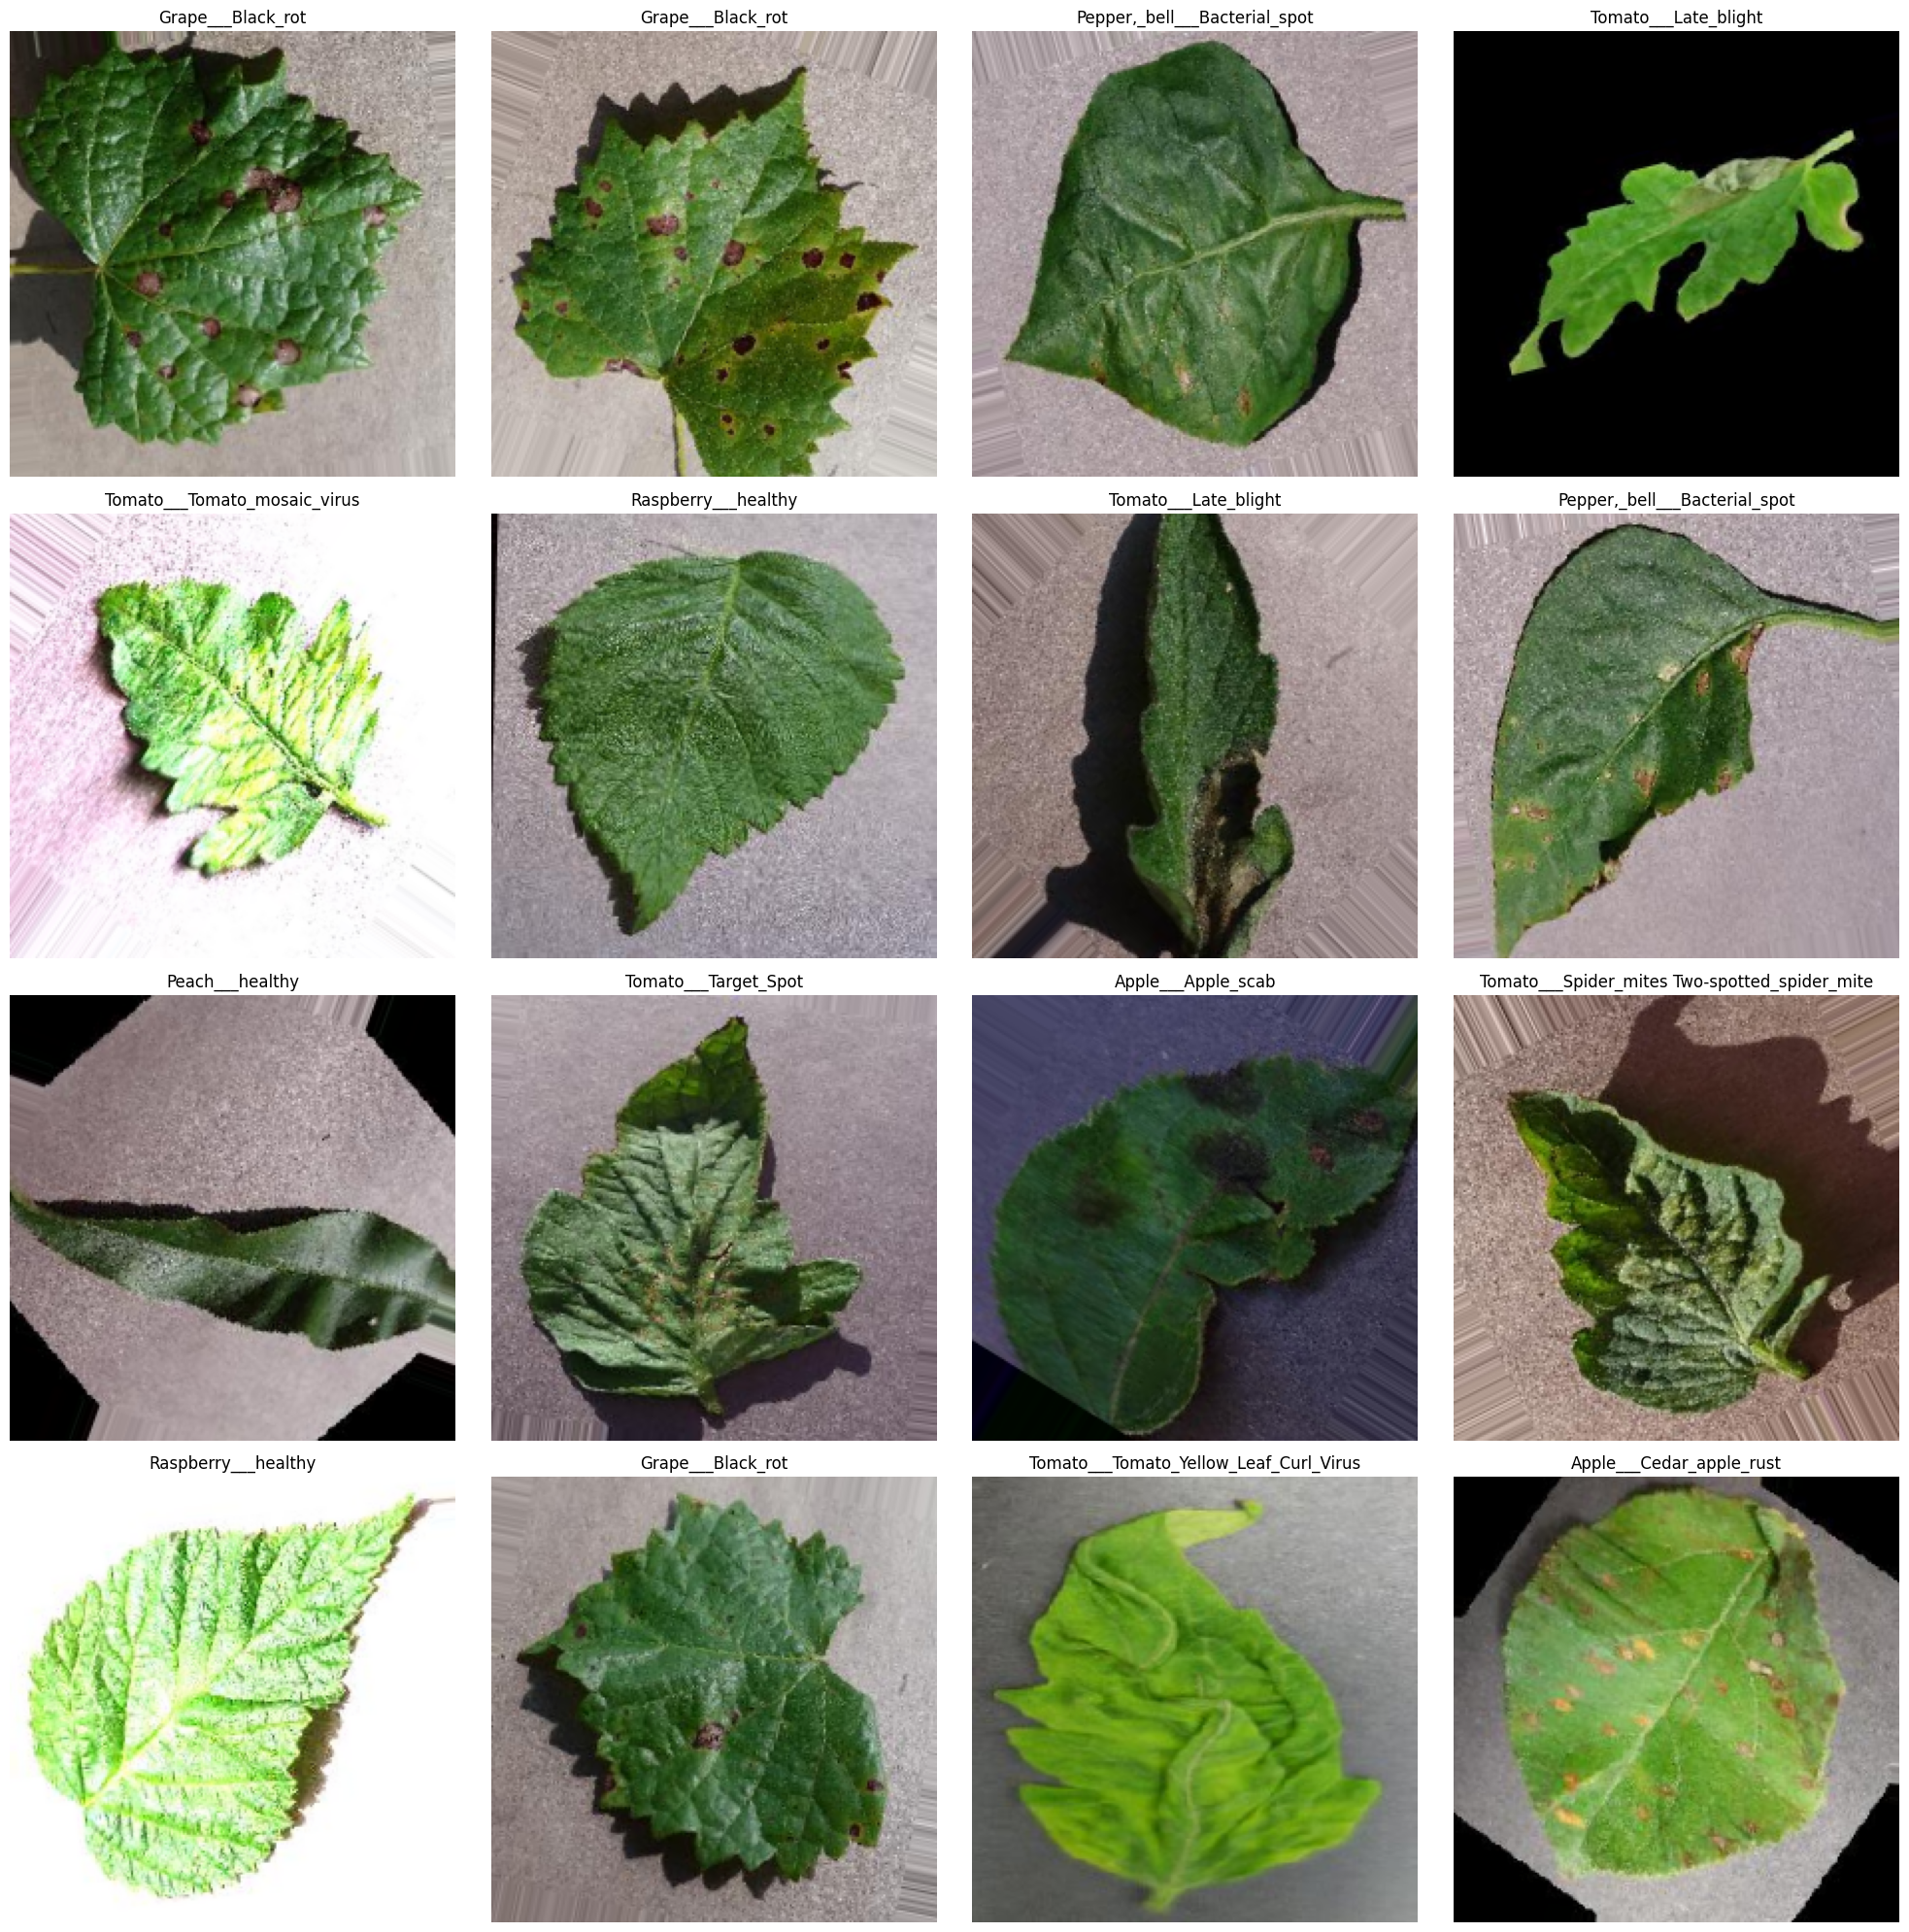

In [10]:
# Visualize 16 samples
plt.figure(figsize=(20, 20))
for X_batch, y_batch in train_generator:
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.argmax(y_batch[i])])
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break

In [11]:
# Validation Generator
valid_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.1
).flow_from_directory(
    valid_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=False,
    color_mode='rgb',
    class_mode='categorical'
)

Found 1742 images belonging to 38 classes.


In [12]:
# Test Generator
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0
).flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False,
    color_mode='rgb',
    class_mode='categorical'
)

Found 17572 images belonging to 38 classes.


In [13]:
# ==== CNN Model ====
model = keras.models.Sequential([
    keras.layers.Conv2D(32, 7, strides=1, padding="same", activation="relu", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="Conv1"),
    keras.layers.MaxPool2D(2, name="Pool1"),

    keras.layers.Conv2D(64, 5, strides=1, padding="same", activation="relu", name="Conv2"),
    keras.layers.MaxPool2D(2, name="Pool2"),

    keras.layers.Conv2D(128, 3, padding="same", activation="relu", name="Conv3"),
    keras.layers.Conv2D(256, 3, padding="same", activation="relu", name="Conv4"),
    keras.layers.MaxPool2D(2, name="Pool3"),

    keras.layers.Flatten(name="Flatten1"),
    keras.layers.Dense(128, activation="relu", name="Dense1"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu", name="Dense2"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(classes), activation="softmax", name="Output")
])

print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 224, 224, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 112, 112, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten1 (Flatten)              │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1 (Dense)                  │ (None, 128)            │    25,690,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,125,990 (99.66 MB)

 Trainable params: 26,125,990 (99.66 MB)

 Non-trainable params: 0 (0.00 B)

None


In [14]:
# ==== Callbacks ====
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=1e-6)
]

In [15]:
# ==== Compile and Train ====
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'precision', 'recall']
)

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 942s 2s/step - accuracy: 0.0541 - loss: 3.6476 - precision: 0.5878 - recall: 0.0126 - val_accuracy: 0.1200 - val_loss: 3.1393 - val_precision: 0.9375 - val_recall: 0.0258 - learning_rate: 0.0010
Epoch 2/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 840s 2s/step - accuracy: 0.1531 - loss: 2.9869 - precision: 0.7177 - recall: 0.0353 - val_accuracy: 0.3737 - val_loss: 2.1222 - val_precision: 0.7946 - val_recall: 0.1177 - learning_rate: 0.0010
Epoch 3/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 832s 2s/step - accuracy: 0.3204 - loss: 2.2444 - precision: 0.6746 - recall: 0.1203 - val_accuracy: 0.5798 - val_loss: 1.4315 - val_precision: 0.8733 - val_recall: 0.2887 - learning_rate: 0.0010
Epoch 4/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 830s 2s/step - accuracy: 0.4494 - loss: 1.8086 - precision: 0.7258 - recall: 0.2401 - val_accuracy: 0.6803 - val_loss: 1.0842 - val_precision: 0.8836 - val_recall: 0.4443 - learning_rate: 0.0010
Epoch 5/10
386/386 ━━━━━━━━━━━━━━━━━━━━ 838s 2s/step - accur

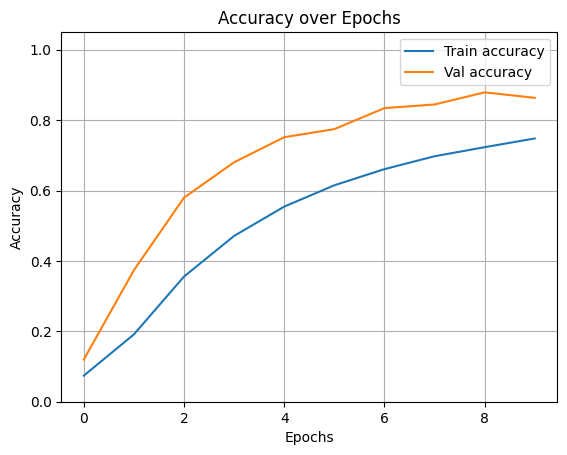

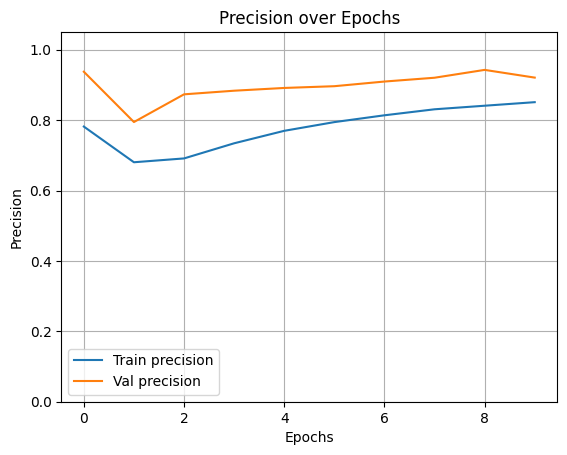

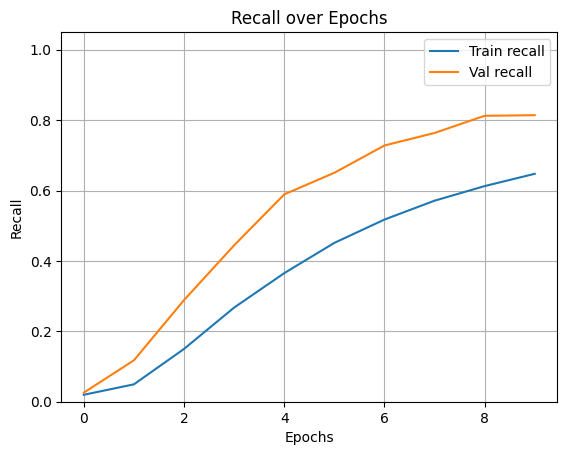

In [16]:
# ==== Evaluation Plots ====
metrics = ['accuracy', 'precision', 'recall', 'loss']
for metric in metrics[:-1]:
    plt.plot(history.history[metric], label=f'Train {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
    plt.title(f'{metric.capitalize()} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
# ==== Final Evaluation ====
results = model.evaluate(test_generator)
print(f"\nTest Results:\nLoss: {results[0]:.4f}\nAccuracy: {results[1]:.4f}\nPrecision: {results[2]:.4f}\nRecall: {results[3]:.4f}")

108/108 ━━━━━━━━━━━━━━━━━━━━ 40s 367ms/step - accuracy: 0.9040 - loss: 0.3420 - precision: 0.9444 - recall: 0.8595

Test Results:
Loss: 0.4115
Accuracy: 0.8802
Precision: 0.9402
Recall: 0.8129


In [18]:
# ==== Save Model ====
model.save('Plant_Disease_Detection.keras')

In [33]:
%%writefile app.py
import streamlit as st
import numpy as np
import tensorflow as tf
from PIL import Image

# Load model once
@st.cache_resource
def load_model():
    return tf.keras.models.load_model("Plant_Disease_Detection.keras")

model = load_model()

# Class names must match the model training order exactly
class_names = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust',
               'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew',
               'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
               'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight',
               'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)',
               'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
               'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot',
               'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy',
               'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy',
               'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew',
               'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot',
               'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold',
               'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite',
               'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
               'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']

# Disease solutions dictionary (accurate and specific)
disease_solutions = {
    "Apple___Apple_scab": "**Apple Scab on Apple - Solution:**\n"
        "- Remove and destroy fallen leaves and infected fruits to reduce fungal spores.\n"
        "- Prune branches to improve air flow and allow leaves to dry quickly.\n"
        "- Apply fungicides like captan or mancozeb before bud break and repeat as per label instructions.\n",

    "Apple___Black_rot": "**Black Rot on Apple - Solution:**\n"
        "- In winter, prune out and destroy cankered branches (dark, sunken spots).\n"
        "- Remove and discard mummified fruit hanging in the tree.\n"
        "- Spray with fungicides such as myclobutanil or captan starting at green tip and repeat as directed.\n",

    "Apple___Cedar_apple_rust": "**Cedar-Apple Rust on Apple - Solution:**\n"
        "- If possible, remove cedar or juniper hosts within 300 m of your orchard.\n"
        "- Prune to open the canopy for better ventilation.\n"
        "- Apply a fungicide like myclobutanil at tight-cluster stage and again at petal fall.\n",

    "Apple___healthy": "**Healthy Apple – Solution:**\n"
        "- No disease detected. Continue regular pruning, inspection, and balanced fertilization.\n"
        "- Monitor for pests and early signs of stress.\n",

    "Blueberry___healthy": "**Healthy Blueberry – Solution:**\n"
        "- No disease detected. Maintain soil pH at 4.5–5.5.\n"
        "- Apply organic mulch (e.g., pine bark) to conserve moisture and suppress weeds.\n",

    "Cherry_(including_sour)___Powdery_mildew": "**Powdery Mildew on Cherry – Solution:**\n"
        "- Spray sulfur or neem oil at first sign of white, powdery patches.\n"
        "- Prune crowded shoots to improve air flow.\n"
        "- Remove and destroy heavily infected leaves.\n",

    "Cherry_(including_sour)___healthy": "**Healthy Cherry – Solution:**\n"
        "- No disease detected. Ensure well-drained soil and prune annually to keep canopy open.\n"
        "- Inspect regularly for pests and nutrient deficiencies.\n",

    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot": "**Gray Leaf Spot on Corn – Solution:**\n"
        "- Plant resistant hybrids when available.\n"
        "- Rotate crops; avoid planting corn in the same field each year.\n"
        "- Avoid overhead irrigation that wets the foliage.\n"
        "- If needed, apply a fungicide like azoxystrobin at the first symptom.\n",

    "Corn_(maize)___Common_rust_": "**Common Rust on Corn – Solution:**\n"
        "- Use rust-resistant varieties.\n"
        "- If spots become heavy, spray tebuconazole during early tasseling.\n",

    "Corn_(maize)___Northern_Leaf_Blight": "**Northern Leaf Blight on Corn – Solution:**\n"
        "- Choose varieties with good resistance ratings.\n"
        "- Rotate with non-host crops and avoid overhead watering.\n"
        "- Apply propiconazole at the initial sign of elongated lesions.\n",

    "Corn_(maize)___healthy": "**Healthy Corn – Solution:**\n"
        "- No disease detected. Maintain even plant spacing and good field hygiene.\n"
        "- Scout regularly for pests and nutrient deficiencies.\n",

    "Grape___Black_rot": "**Black Rot on Grape – Solution:**\n"
        "- Prune out and destroy infected shoots and mummified berries.\n"
        "- Remove any fallen fruit or debris from under the vine.\n"
        "- Apply mancozeb or myclobutanil sprays at bloom and pre-bunch closure.\n",

    "Grape___Esca_(Black_Measles)": "**Esca (Black Measles) on Grape – Solution:**\n"
        "- Avoid pruning in wet weather to minimize spore spread.\n"
        "- Cut out and destroy infected vines and cordons.\n"
        "- Focus on sanitation; no effective chemical control is available.\n",

    "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)": "**Isariopsis Leaf Spot on Grape – Solution:**\n"
        "- Remove and destroy infected leaves promptly.\n"
        "- Ensure good air flow by proper spacing and pruning.\n"
        "- Spray chlorothalonil at the first sign of spots and follow up as needed.\n",

    "Grape___healthy": "**Healthy Grape – Solution:**\n"
        "- No disease detected. Keep up regular pruning, balanced fertilization, and scouting.\n",

    "Orange___Haunglongbing_(Citrus_greening)": "**Huanglongbing (Citrus Greening) on Orange – Solution:**\n"
        "- Remove and destroy any infected trees immediately.\n"
        "- Control the Asian citrus psyllid vector with approved insecticides.\n"
        "- Always plant certified, disease-free nursery stock.\n",

    "Peach___Bacterial_spot": "**Bacterial Spot on Peach – Solution:**\n"
        "- Use resistant varieties when available.\n"
        "- Avoid overhead watering to keep foliage dry.\n"
        "- Apply copper-based bactericides at bud break and repeat per label.\n",

    "Peach___healthy": "**Healthy Peach – Solution:**\n"
        "- No disease detected. Monitor for pests, prune for airflow, and maintain proper irrigation.\n",

    "Pepper,_bell___Bacterial_spot": "**Bacterial Spot on Bell Pepper – Solution:**\n"
        "- Remove and destroy infected leaves and fruit.\n"
        "- Spray copper-based formulations early and repeat as needed.\n"
        "- Rotate pepper beds and avoid working with wet plants.\n",

    "Pepper,_bell___healthy": "**Healthy Bell Pepper – Solution:**\n"
        "- No disease detected. Maintain good spacing and apply balanced fertilizers.\n",

    "Potato___Early_blight": "**Early Blight on Potato – Solution:**\n"
        "- Use certified disease-free seed potatoes.\n"
        "- Remove and destroy old plant debris after harvest.\n"
        "- Apply fungicides like chlorothalonil at first signs of leaf spots.\n",

    "Potato___Late_blight": "**Late Blight on Potato – Solution:**\n"
        "- Destroy infected plants immediately; do not compost.\n"
        "- Avoid overhead watering and improve air circulation.\n"
        "- Apply protective fungicides such as mancozeb regularly during humid periods.\n",

    "Potato___healthy": "**Healthy Potato – Solution:**\n"
        "- No disease detected. Continue monitoring, use mulch, and ensure even watering.\n",

    "Raspberry___healthy": "**Healthy Raspberry – Solution:**\n"
        "- No disease detected. Prune regularly to remove old canes.\n"
        "- Watch for pests such as aphids and spider mites.\n",

    "Soybean___healthy": "**Healthy Soybean – Solution:**\n"
        "- No disease detected. Rotate crops and scout fields regularly for early signs of disease.\n",

    "Squash___Powdery_mildew": "**Powdery Mildew on Squash – Solution:**\n"
        "- Apply sulfur-based fungicides or neem oil at first sign of white powder.\n"
        "- Space plants adequately to improve air flow.\n"
        "- Avoid wetting leaves when watering.\n",

    "Strawberry___Leaf_scorch": "**Leaf Scorch on Strawberry – Solution:**\n"
        "- Remove infected leaves and apply a nitrogen-rich fertilizer.\n"
        "- Avoid overhead irrigation to keep foliage dry.\n"
        "- Apply fungicides like thiophanate-methyl or copper-based sprays.\n"
        "- Space plants adequately to improve air flow.\n",

    "Strawberry___healthy": "**Healthy Strawberry – Solution:**\n"
        "- No disease detected. Ensure good soil drainage and use mulch to preserve moisture.\n"
        "- Monitor regularly for pests and nutrient needs.\n",

    "Tomato___Bacterial_spot": "**Bacterial Spot on Tomato – Solution:**\n"
        "- Remove and destroy affected leaves immediately.\n"
        "- Apply copper-based sprays early in the season.\n"
        "- Rotate crops and avoid overhead watering.\n",

    "Tomato___Early_blight": "**Early Blight on Tomato – Solution:**\n"
        "- Use mulch to prevent soil splash onto leaves.\n"
        "- Remove and destroy infected foliage.\n"
        "- Apply fungicides such as chlorothalonil at first signs of spots.\n",

    "Tomato___Late_blight": "**Late Blight on Tomato – Solution:**\n"
        "- Destroy infected plants immediately and remove all debris.\n"
        "- Apply fungicides containing mancozeb or chlorothalonil regularly.\n"
        "- Avoid high humidity and improve air flow.\n",

    "Tomato___Leaf_Mold": "**Leaf Mold on Tomato – Solution:**\n"
        "- Improve ventilation by pruning lower leaves.\n"
        "- Use resistant varieties when possible.\n"
        "- Apply fungicides like chlorothalonil if needed.\n",

    "Tomato___Septoria_leaf_spot": "**Septoria Leaf Spot on Tomato – Solution:**\n"
        "- Remove lower leaves to reduce humidity.\n"
        "- Apply fungicides such as mancozeb at the first sign of spots.\n"
        "- Avoid wetting foliage when irrigating.\n",

    "Tomato___Spider_mites Two-spotted_spider_mite": "**Two-Spotted Spider Mite on Tomato – Solution:**\n"
        "- Spray with insecticidal soap or neem oil directly on undersides of leaves.\n"
        "- Increase humidity around plants to discourage mites.\n"
        "- Remove and destroy heavily infested leaves.\n",

    "Tomato___Target_Spot": "**Target Spot on Tomato – Solution:**\n"
        "- Remove infected leaves and debris.\n"
        "- Apply fungicides like chlorothalonil at first signs of target-shaped lesions.\n"
        "- Ensure proper plant spacing for air circulation.\n",

    "Tomato___Tomato_Yellow_Leaf_Curl_Virus": "**Tomato Yellow Leaf Curl Virus – Solution:**\n"
        "- Remove and destroy infected plants immediately.\n"
        "- Control whitefly vectors with insecticidal soap or neem oil.\n"
        "- Plant resistant tomato varieties if available.\n",

    "Tomato___Tomato_mosaic_virus": "**Tomato Mosaic Virus – Solution:**\n"
        "- Destroy infected plants and disinfect tools between uses.\n"
        "- Wash hands and tools before handling healthy plants.\n"
        "- Avoid smoking near plants to reduce virus spread.\n",

    "Tomato___healthy": "**Healthy Tomato – Solution:**\n"
        "- No disease detected. Maintain balanced watering and fertilization.\n"
        "- Inspect regularly for early signs of pests or stress.\n"
}



IMAGE_SIZE = (224, 224)

# Page layout
st.set_page_config(page_title="🌿 Plant Disease Detection", layout="centered")
st.markdown("<h1 style='text-align: center;'>🌿 Plant Disease Detector</h1>", unsafe_allow_html=True)
st.markdown("<p style='text-align: center;'>Upload a plant leaf image to identify the disease</p>", unsafe_allow_html=True)

# Upload Image
uploaded_file = st.file_uploader("📤 Upload Leaf Image", type=['jpg', 'jpeg', 'png'])

if uploaded_file:
    image = Image.open(uploaded_file).convert("RGB")
    st.image(image, caption="Uploaded Image", use_container_width=True)

    # Preprocess
    img = image.resize(IMAGE_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    if st.button("🚀 Predict Disease"):
        with st.spinner("Analyzing..."):
            prediction = model.predict(img_array)
            predicted_class = class_names[np.argmax(prediction)]

        st.success(f"✅ Prediction: `{predicted_class}`")

        # Show solution
        solution = disease_solutions.get(predicted_class, "No specific solution found.")
        st.markdown("### 🌱 Suggested Solution")
        st.info(solution)


Overwriting app.py


In [26]:
# ==== Deploy with Ngrok ====
!pip install streamlit pyngrok

In [21]:
!ngrok authtoken 30k7bad1I9qCibfc3XtsvlW2WUu_5YTnbmujyG9sZhmQNgVLN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [22]:
!pkill -f ngrok
!ps aux | grep ngrok

root       38526  0.0  0.0   7376  3512 ?        S    09:22   0:00 /bin/bash -c ps aux | grep ngrok
root       38528  0.0  0.0   6484  2268 ?        S    09:22   0:00 grep ngrok


In [23]:
import os
import threading
def run_streamlit():
    os.system('streamlit run app.py --server.port 8501')
thread = threading.Thread(target=run_streamlit)
thread.start()

In [24]:
from pyngrok import ngrok
import time
time.sleep(15)
public_url = ngrok.connect(8501)
print('app live here: ',public_url)

app live here:  NgrokTunnel: "https://f257122b5c57.ngrok-free.app" -> "http://localhost:8501"
